In [1]:
import sys
sys.path.append('..')
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdn
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
import os
import json
from shapely.geometry import Point

warnings.filterwarnings("ignore")

In [3]:
idx = 'a'
if not idx.isdigit():
    print('miuau')

miuau


In [2]:
from glob import glob
glob('/app/assets/streets/*/nodes')

['/app/assets/streets/actual/nodes', '/app/assets/streets/future/nodes']

In [3]:
def get_nodes_and_edges_in_plate(nodes, edges, plate):
    select_nodes = gpd.sjoin(nodes, plate, how='inner')
    select_edges = edges[edges['u'].isin(select_nodes.osmid) | edges['v'].isin(select_nodes.osmid)]
    select_nodes = nodes[nodes['osmid'].isin(select_edges['u']) | nodes['osmid'].isin(select_edges['v'])]
    return select_nodes, select_edges

In [4]:
default_crs = '32718'

In [5]:
actual_nodes = gpd.read_file('/app/assets/streets/actual/nodes').to_crs(default_crs)
actual_edges = gpd.read_file('/app/assets/streets/actual/edges').to_crs(default_crs)

In [42]:
# future_nodes = gpd.read_file('/app/assets/streets/future/nodes').to_crs(default_crs)
# future_edges = gpd.read_file('/app/assets/streets/future/edges').to_crs(default_crs)
future_nodes = gpd.read_parquet('/app/assets/streets/future/nodes.parquet').to_crs(default_crs)
future_edges = gpd.read_parquet('/app/assets/streets/future/edges.parquet').to_crs(default_crs)

In [7]:
area_scope = gpd.read_file('/app/assets/area_scope').to_crs(default_crs)

In [43]:
actual_edges['plate_id'] = 0
actual_nodes['plate_id'] = 0
future_edges['plate_id'] = 0
future_nodes['plate_id'] = 0

In [48]:
future_edges.reset_index(inplace=True)
future_nodes.reset_index(inplace=True)

In [49]:
def labeling_plate_id(nodes, edges):
    for plate_id in np.arange(1,9):
        # print(plate_id)
        plate = gpd.read_file(f'/app/assets/plates/{plate_id}').to_crs(default_crs)

        select_nodes = gpd.sjoin(nodes, plate, how='inner')
        edges_mask = edges['u'].isin(select_nodes['osmid']) | edges['v'].isin(select_nodes['osmid'])
        select_edges = edges[edges_mask]
        nodes_mask = [True]*len(nodes)
        # nodes_mask = nodes_mask & nodes['osmid'].isin(select_nodes['osmid'])
        nodes_mask = nodes_mask & (nodes['osmid'].isin(select_edges['u']) | nodes['osmid'].isin(select_edges['v']))
        # nodes_mask = nodes_mask & nodes['osmid'].isin(select_nodes['osmid'])
        select_nodes = nodes[nodes_mask]
        edges_mask = edges['u'].isin(select_nodes['osmid']) | edges['v'].isin(select_nodes['osmid'])

        nodes.loc[nodes_mask, 'plate_id'] = plate_id
        edges.loc[edges_mask, 'plate_id'] = plate_id
        
        nodes = gpd.GeoDataFrame(data=nodes.drop(columns=['geometry']), geometry=nodes['geometry'])
        edges = gpd.GeoDataFrame(data=edges.drop(columns=['geometry']), geometry=edges['geometry'])
    return nodes, edges

nodes = actual_nodes.copy()
edges = actual_edges.copy()
nodes, edges = labeling_plate_id(nodes, edges)
nodes.to_parquet('/app/assets/streets/actual/nodes.parquet')
edges.to_parquet('/app/assets/streets/actual/edges.parquet')

nodes = future_nodes.copy()
edges = future_edges.copy()
nodes, edges = labeling_plate_id(nodes, edges)
nodes.to_parquet('/app/assets/streets/future/nodes.parquet')
edges.to_parquet('/app/assets/streets/future/edges.parquet')

# mask_future_edges = ~select_future_edges['osmid'].isin(select_actual_edges['osmid'])
# edges_to_change = gpd.sjoin(select_future_edges[mask_future_edges], plate, how='inner')

<Axes: >

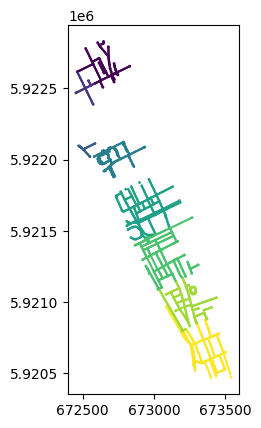

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
nodes[nodes['plate_id']!=0].plot(column='plate_id', markersize=1, ax=ax)
edges[edges['plate_id']!=0].plot(column='plate_id', ax=ax)

In [59]:
nodes.to_parquet('/app/assets/streets/future/nodes.parquet')
edges.to_parquet('/app/data/output/edges.parquet')

In [60]:
nodes = gpd.read_parquet('/app/data/output/nodes.parquet')

In [61]:
edges = gpd.read_parquet('/app/data/output/edges.parquet')

In [54]:
nodes = gpd.read_file('/app/assets/streets/actual/nodes')

<Axes: >

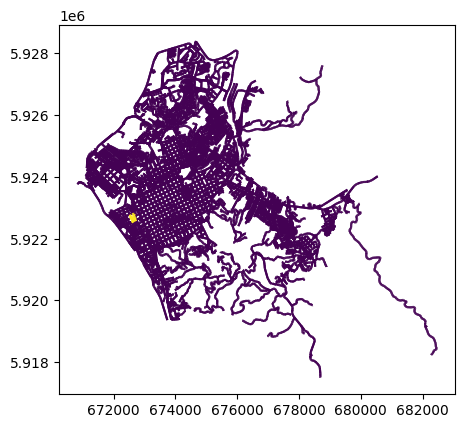

In [49]:
edges.plot(column='plate_id')

<Axes: >

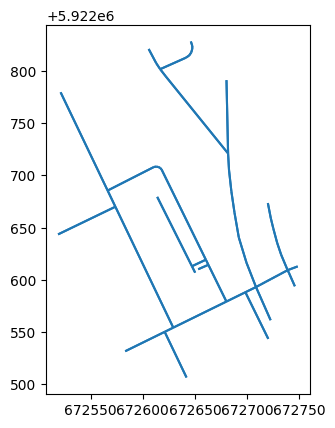

In [32]:
select_edges.plot()

In [42]:
n_plate = '6'
# for n_plate in range(8):
plate = gpd.read_file(f'/app/assets/plates/{n_plate}').to_crs(default_crs)
select_actual_nodes, select_actual_edges = get_nodes_and_edges_in_plate(actual_nodes, actual_edges, plate)
select_future_nodes, select_future_edges = get_nodes_and_edges_in_plate(future_nodes, future_edges, plate)

# mask_future_edges = ~select_future_edges['osmid'].isin(select_actual_edges['osmid'])
# future_edges_to_change = gpd.sjoin(select_future_edges[mask_future_edges], plate, how='inner')

# mask_actual_edges = ~select_actual_edges['osmid'].isin(select_future_edges['osmid'])
# actual_edges_to_change = gpd.sjoin(select_actual_edges[mask_actual_edges], plate, how='inner')
# print(f'{n_plate} : {edges_to_change.shape}')

<Axes: >

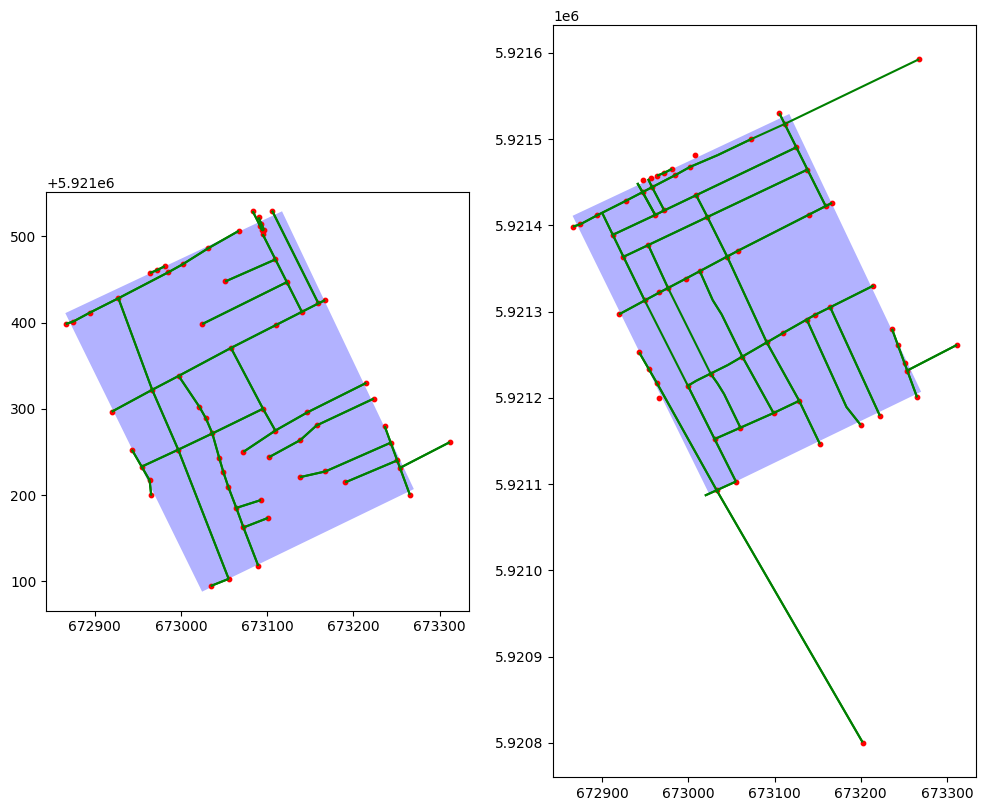

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12,18))
plate.plot(ax=ax[0], color='blue', alpha=0.3)
select_actual_nodes.plot(ax=ax[0], color='red', markersize=10)
select_actual_edges.plot(ax=ax[0], color='green', markersize=0.5)

plate.plot(ax=ax[1], color='blue', alpha=0.3)
select_future_nodes.plot(ax=ax[1], color='red', markersize=10)
select_future_edges.plot(ax=ax[1], color='green', markersize=0.5)

# plate.plot(ax=ax[2], color='blue', alpha=0.3)
# select_actual_edges.plot(ax=ax[2], color='green', markersize=0.5)
# actual_edges_to_change.plot(ax=ax[2], color='red', markersize=20)

# plate.plot(ax=ax[3], color='blue', alpha=0.3)
# select_future_edges.plot(ax=ax[3], color='green', markersize=0.5)
# future_edges_to_change.plot(ax=ax[3], color='red', markersize=20)

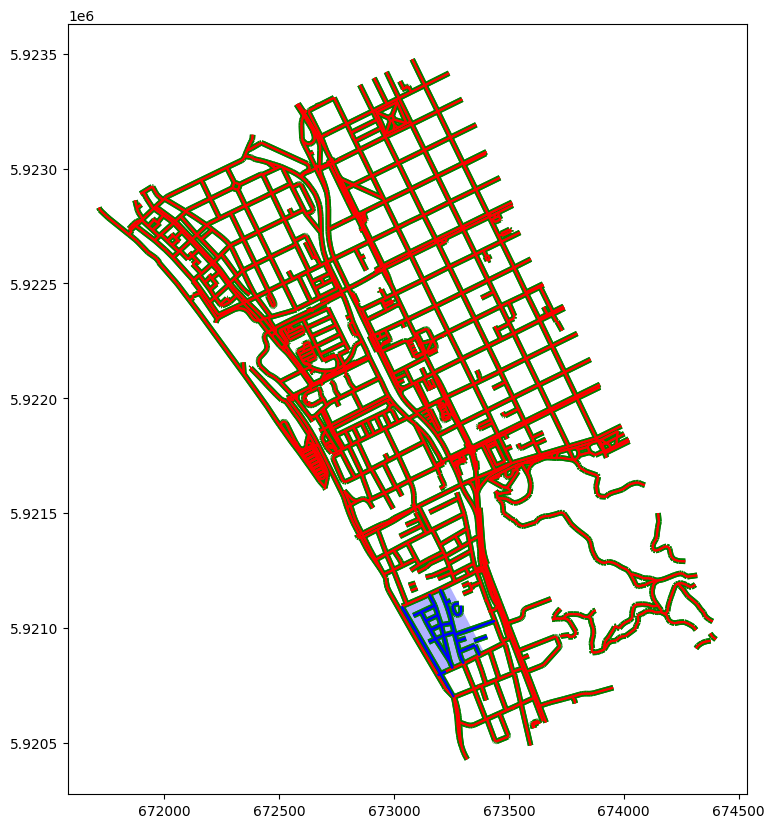

In [29]:
n_plate = '7'
# for n_plate in range(8):
plate = gpd.read_file(f'/app/assets/plates/{n_plate}').to_crs(default_crs)
select_actual_nodes, select_actual_edges = get_nodes_and_edges_in_plate(actual_nodes, actual_edges, plate)
select_future_nodes, select_future_edges = get_nodes_and_edges_in_plate(future_nodes, future_edges, plate)
mask_future_edges = ~select_future_edges['osmid'].isin(select_actual_edges['osmid'])
new_edges = gpd.sjoin(select_future_edges[mask_future_edges], plate, how='inner')

deleted_actual_edges = actual_edges[~actual_edges['osmid'].isin(select_actual_edges['osmid'])]
deleted_actual_nodes = actual_nodes[~actual_nodes['osmid'].isin(select_actual_nodes['osmid'])]

edges_updated = pd.concat([deleted_actual_edges, select_future_edges])
nodes_updated = pd.concat([deleted_actual_nodes, select_future_nodes])

deleted_actual_edges = gpd.sjoin(deleted_actual_edges, area_scope, how='inner')
select_future_edges = gpd.sjoin(select_future_edges, area_scope, how='inner')
edges_updated = gpd.sjoin(edges_updated, area_scope, how='inner')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
plate.plot(ax=ax, color='blue', alpha=0.3)
edges_updated.plot(ax=ax, color='green', linewidth=4)
deleted_actual_edges.plot(ax=ax, color='red', markersize=10)
select_future_edges.plot(ax=ax, color='blue', markersize=10)
def extract_sub_network(nodes, edges, plate):
    return None

In [3]:
import os
from glob import glob

plates_path = '/app/assets/plates'
plates_files = glob(os.path.join(plates_path, '*'))

In [9]:
file = plates_files[0]
file
os.path.split(file)[-1]

'1'

In [2]:
future_nodes = gpd.read_file('/app/data/red/nodes')
future_edges = gpd.read_file('/app/data/red/edges')

In [5]:
future_nodes['osmid'] = pd.NA
future_nodes = future_nodes[['osmid', 'geometry']]
future_nodes.to_file('/app/data/chatgpt/red/future/nodes')

In [8]:
future_edges = future_edges[['geometry']]
future_edges['osmid'] = pd.NA
future_edges[['u', 'v']] = pd.NA
future_edges['key'] = 0

In [11]:
future_edges.to_file('/app/data/chatgpt/red/future/edges')

In [33]:
actual_nodes = gpd.read_file('/app/assets/streets/actual/nodes').to_crs(32718)
actual_edges = gpd.read_file('/app/assets/streets/actual/edges').to_crs(32718)

In [46]:
future_nodes = gpd.read_file('/app/assets/streets/future/nodes')
future_edges = gpd.read_file('/app/assets/streets/future/edges')
future_nodes.to_parquet('/app/assets/streets/future/nodes.parquet')
future_edges.to_parquet('/app/assets/streets/future/edges.parquet')

In [34]:
actual_edges['geometry'].isin(future_edges['geometry']).sum()

0

In [44]:
# import osmnx as ox
# graph = ox.graph_from_place(
#     "Concepción, Chile",
#     network_type="walk",
#     simplify=False,
# )

In [45]:
# actual_nodes, actual_edges = ox.graph_to_gdfs(graph)
# actual_nodes = actual_nodes.to_crs(32718)
# actual_edges = actual_edges.to_crs(32718)

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(100,100))
future_edges.plot(ax=ax, markersize=10, color='red')
actual_edges.plot(ax=ax, markersize=10, color='blue')
actual_nodes.plot(ax=ax, markersize=8, color='blue')

<Axes: >

In [13]:
actual_nodes

osmid          y          x  street_cou   highway  \
0        267252253 -36.826699 -73.040321           2       NaN   
1        267252256 -36.826739 -73.040342           4  crossing   
2        267252355 -36.826220 -73.037381           4       NaN   
3        267548089 -36.792384 -73.025375           2       NaN   
4        267548092 -36.795691 -73.025772           2       NaN   
...            ...        ...        ...         ...       ...   
35904  11273632213 -36.819161 -73.014258           2       NaN   
35905  11273632214 -36.819240 -73.014267           2       NaN   
35906  11273632215 -36.819280 -73.014277           2       NaN   
35907  11273632216 -36.819201 -73.014261           2       NaN   
35908  11273632217 -36.813723 -73.050076           1       NaN   

                          geometry  
0      POINT (-73.04032 -36.82670)  
1      POINT (-73.04034 -36.82674)  
2      POINT (-73.03738 -36.82622)  
3      POINT (-73.02537 -36.79238)  
4      POINT (-73.02577 -36.79569)  
...                            ...  
35904  POINT (-73.01426 -36.81916)  
35905  POINT (-73.01427 -36.81924)  
35906  POINT (-73.01428 -36.81928)  
35907  POINT (-73.01426 -36.81920)  
35908  POINT (-73.05008 -36.81372)  

[35909 rows x 6 columns]